# **Klasifikasi Gambar Buah Segar**

Buah-buahan seperti pisang, apel, dan jeruk merupakan komoditas penting dalam kehidupan sehari-hari. Namun, kualitas buah-buahan tersebut sangat cepat menurun jika tidak ditangani dengan baik. Deteksi kondisi buah (segar atau busuk) secara otomatis dapat membantu mengurangi pemborosan makanan, meningkatkan efisiensi distribusi, dan membantu pelaku usaha seperti penjual buah atau pengelola gudang dalam pengambilan keputusan. Oleh karena itu, tujuan dari proyek ini adalah membangun model klasifikasi gambar untuk membedakan buah yang segar dan busuk secara otomatis.

## **Deskripsi Dataset**
Dataset yang digunakan adalah “Fruits Fresh and Rotten for Classification” yang tersedia di Kaggle. Dataset ini berisi gambar dari tiga jenis buah dalam dua kondisi:


🍌 Pisang: freshbanana, rottenbanana

🍎 Apel: freshapple, rottenapple

🍊 Jeruk: freshorange, rottenorange

Setiap gambar memiliki resolusi yang bervariasi dan diambil dalam berbagai kondisi pencahayaan dan sudut pandang, sehingga memberikan tantangan menarik untuk klasifikasi berbasis visual.

## **Tujuan Akhir dan Potensi Penggunaan**
Model yang dikembangkan diharapkan mampu secara akurat:
- Mengklasifikasikan gambar buah sebagai segar atau busuk.

- Digunakan sebagai bagian dari sistem sortir otomatis, pengawasan mutu produk, atau bahkan sebagai fitur aplikasi seluler untuk konsumen dan penjual.

## **Sumber Dataset**
https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

# Import library

In [1]:
# Untuk manajemen file dan operasi sistem
import os, shutil
import zipfile
import random
import pathlib
from pathlib import Path
import datetime

# Untuk manipulasi data dan preprocessing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from re import sub

# Untuk visualisasi data dan gambar
import matplotlib.image as imread
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk pembagian data dan evaluasi performa model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Untuk mengembangkan dan melatih model CNN
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

# Untuk callbacks saat pelatihan model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, TensorBoard

# Untuk mengabaikan peringatan yang tidak penting
import warnings
warnings.filterwarnings('ignore')

# Untuk mengakses Google Drive dari Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Untuk konversi model ke format TensorFlow.js
!pip install tensorflowjs
import tensorflowjs as tfjs

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


# Load data

Untuk mengakses dataset dari Kaggle secara langsung di Google Colab, diperlukan file autentikasi `kaggle.json` yang berisi API key dari akun Kaggle pengguna. Langkah-langkah berikut dilakukan:

**1. Unggah File `kaggle.json`**
- File ini dapat diunduh dari halaman akun API Kaggle
- Diunggah ke Colab menggunakan perintah `files.upload()`

**2. Menyimpan dan Menyetel Izin File**
- File `kaggle.json` dipindahkan ke direktori `~/.kaggle`
- Diberikan izin akses yang sesuai agar dapat digunakan oleh perintah `kaggle`

**3. Mengunduh dan Mengekstrak Dataset**
- Dataset "Fruits Fresh and Rotten for Classification" diunduh
- Dataset diekstrak agar siap digunakan dalam proses pelatihan model

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syafiqirz","key":"0c72a1adc783a76faa4c305222ff24b2"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification
!unzip fruits-fresh-and-rotten-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

Dataset asli dibagi menjadi dua folder: train dan test, masing-masing berisi subfolder untuk setiap kategori (misalnya freshapple, rottenbanana, dll).
Langkah berikut dilakukan untuk menggabungkan semua gambar dari kedua folder ini ke dalam satu direktori baru bernama combined, sehingga memudahkan proses seperti split ulang atau eksplorasi data

In [5]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"
combined_dir = "/content/dataset/combined"
os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Explore

## Menampilkan Contoh Gambar dari Tiap Kelas

Visualisasi ini menampilkan **plot batang horizontal (countplot)** untuk menunjukkan jumlah gambar per kelas dalam dataset. Tujuan analisis ini adalah:

- Memahami distribusi data
- Mengevaluasi apakah dataset seimbang atau mengalami ketimpangan (imbalance)

**Hasil Observasi**

Dari output yang dihasilkan, dapat disimpulkan:

- **Kelas dominan**:
  - `rottenbanana`: ~2900 gambar
  - `rottenapples`: ~2700 gambar

- **Kelas minoritas**:
  - Empat kelas lainnya berkisar antara 1800–2100 gambar

**Kesimpulan**
Dataset menunjukkan **ketimpangan moderat** dengan karakteristik:
- Perbedaan ±900 gambar antara kelas terbanyak dan tersedikit
- Ketidakseimbangan ini berpotensi memengaruhi performa model jika tidak ditangani dengan tepat

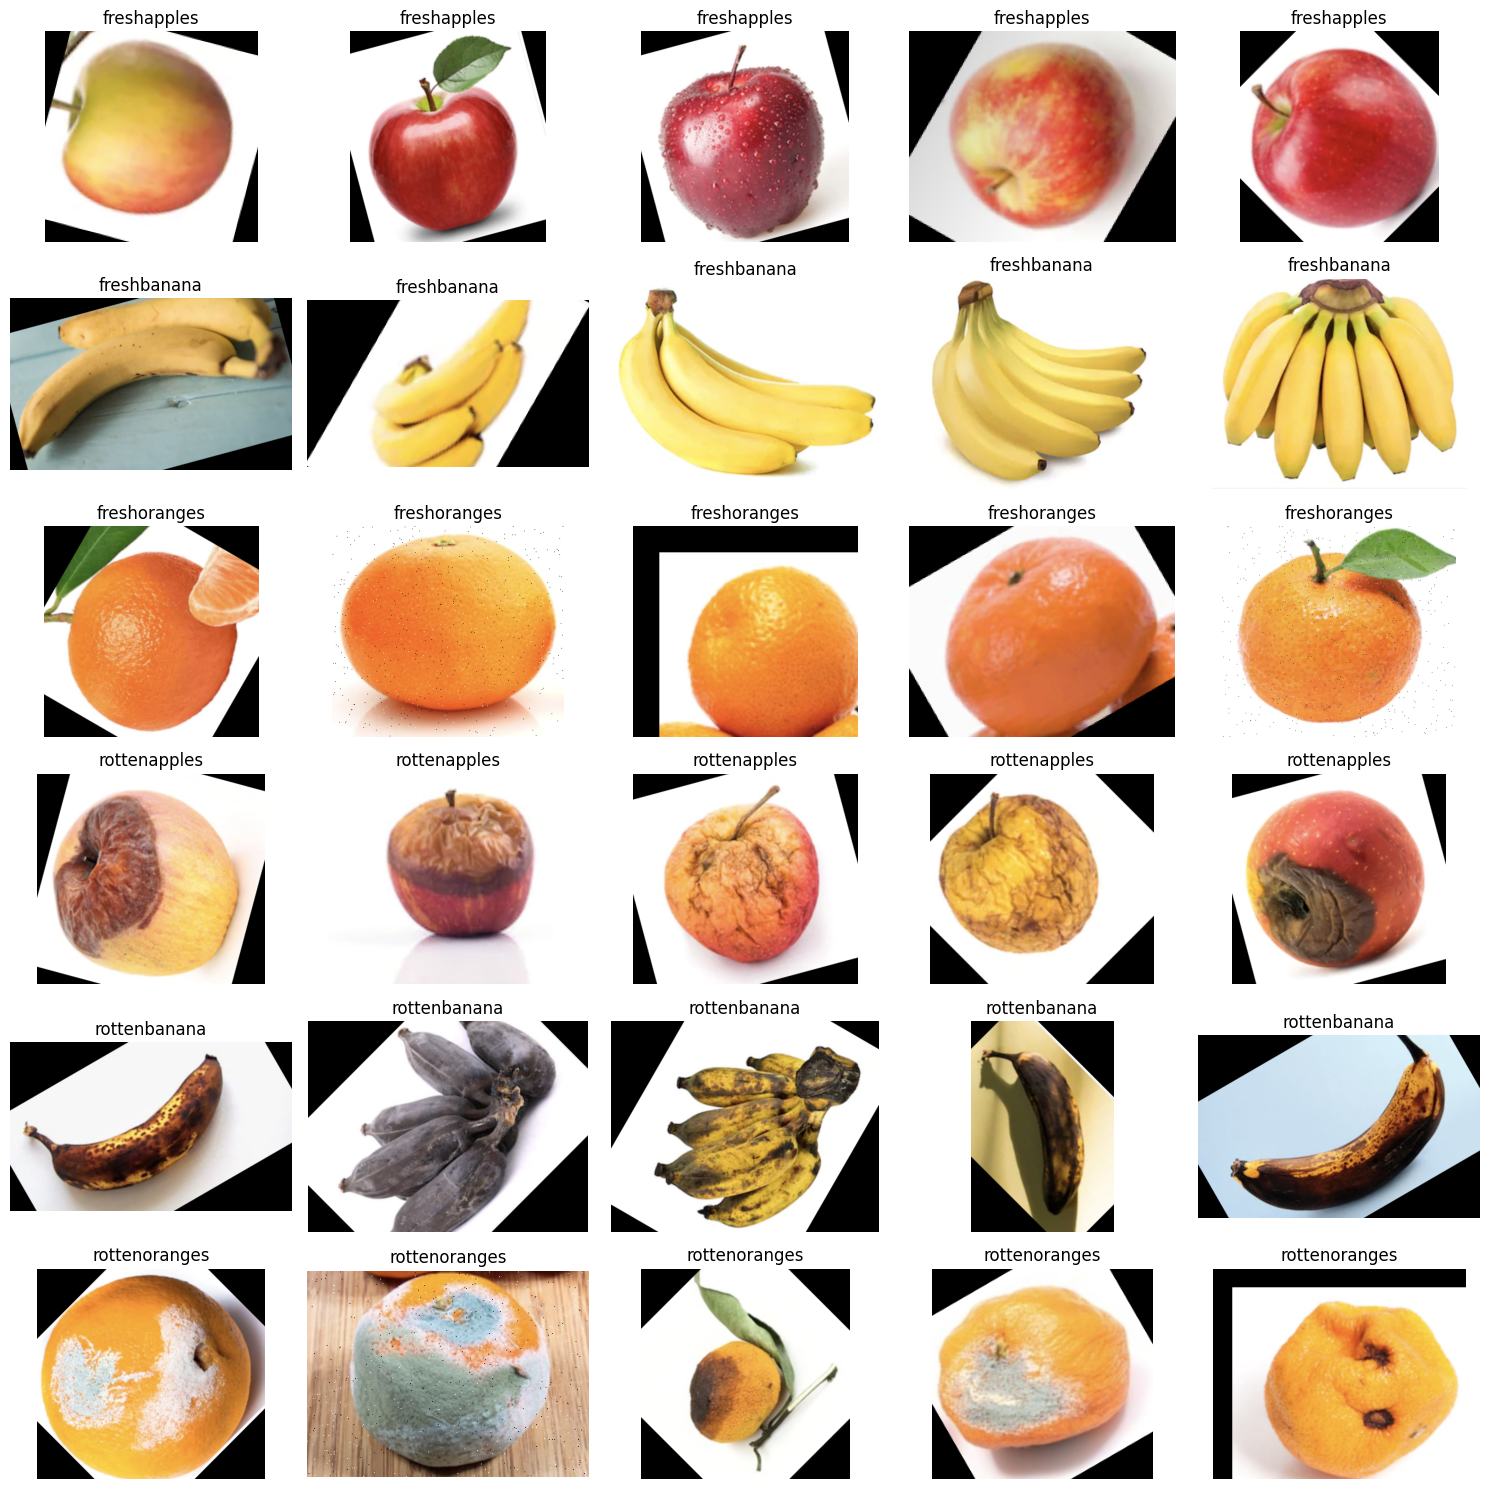

In [6]:
num_samples = 5  # Jumlah gambar per kelas
plt.figure(figsize=(15, 15))

all_categories = sorted(os.listdir(combined_dir))

for i, category in enumerate(all_categories):
    category_path = os.path.join(combined_dir, category)
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]  # Ambil semua gambar
        if image_files:
            random_samples = random.sample(image_files, min(num_samples, len(image_files)))  # Pilih sampel acak
            for j, image_file in enumerate(random_samples):
                img_path = os.path.join(category_path, image_file)
                img = plt.imread(img_path)
                plt.subplot(len(all_categories), num_samples, i * num_samples + j + 1)  # Subplot posisi
                plt.imshow(img)
                plt.title(category)  # Judul kategori
                plt.axis('off')

plt.tight_layout()
plt.show()

## Visualisasi Distribusi Label

Sel ini membuat plot batang horizontal (countplot) untuk menunjukkan jumlah gambar per kelas dalam dataset. Ini penting untuk mengetahui apakah dataset seimbang atau tidak.

Dari output di bawah, diketahui bahwa sebaran data tidak sepenuhnya seimbang. Diketahui bahwa rottenbanana dan rotten apple memiliki jumlah data di sekitar 2700 yang sedikit lebih banyak dari keempat kelas lainnya yang memiliki jumlah data di kisaran 2000.

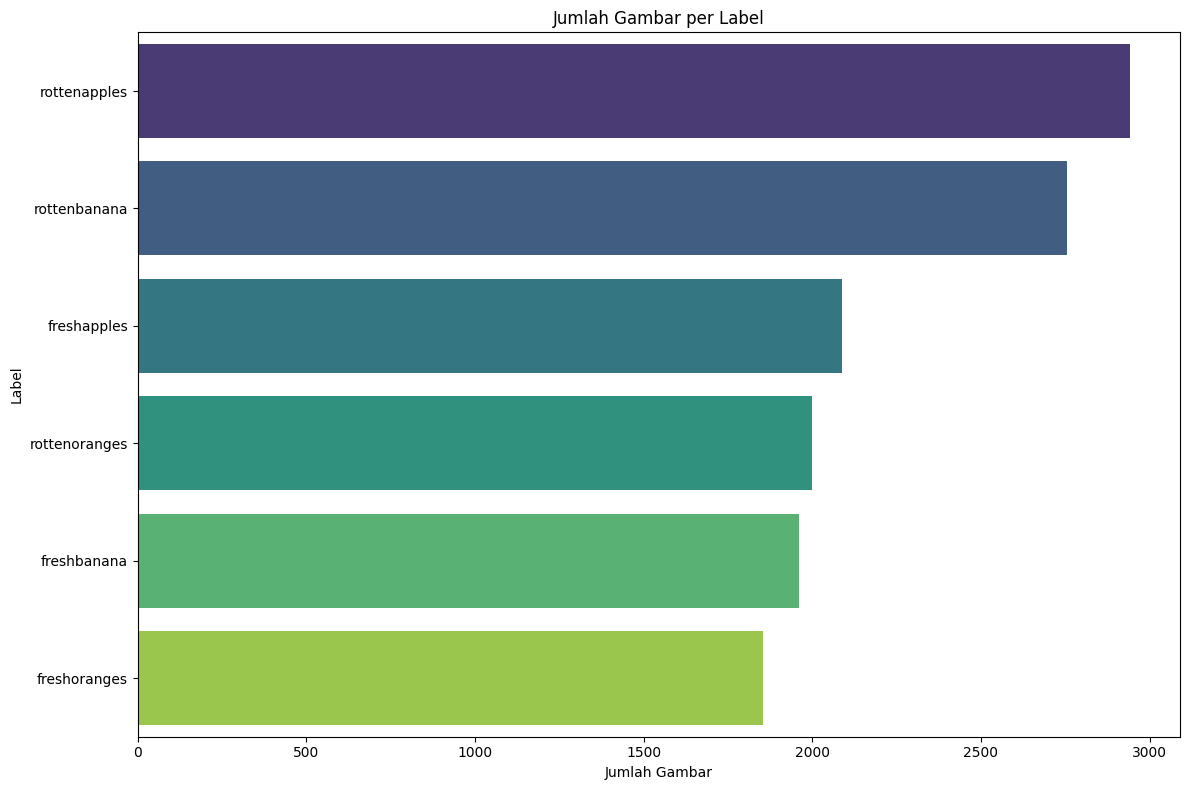

In [7]:
labels = []

for category in os.listdir(combined_dir):
    category_path = os.path.join(combined_dir, category)
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]  # Ambil gambar
        labels.extend([category] * len(image_files))  # Tambahkan label sebanyak jumlah gambar

# Buat DataFrame dari label
df_labels = pd.DataFrame({'label': labels})

# Visualisasi jumlah gambar per label
plt.figure(figsize=(12, 8))
sns.countplot(data=df_labels, y='label', order=df_labels['label'].value_counts().index, palette='viridis')
plt.title('Jumlah Gambar per Label')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

## Menampilkan Jumlah Gambar per Kelas (Teks)

Sel ini mencetak jumlah gambar untuk masing-masing kelas dalam bentuk teks. Berguna untuk debugging dan memastikan semua data berhasil dimuat dengan benar.
Kode ini menghasilkan output jumlah gambar tiap kelas dengan lebih jelas. Dengan ini, kita dapat mengetahui jumlah pasti dari tiap kelas.

In [8]:
label_counts = {}

for category in os.listdir(combined_dir):
    category_path = os.path.join(combined_dir, category)
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]  # Hitung gambar
        label_counts[category] = len(image_files)  # Simpan jumlah ke dictionary

# Cetak jumlah gambar per kelas
print("Jumlah Gambar per Kelas:")
for label, count in label_counts.items():
    print(f"Kelas '{label}': {count} gambar")

Jumlah Gambar per Kelas:
Kelas 'rottenbanana': 2754 gambar
Kelas 'rottenoranges': 1998 gambar
Kelas 'rottenapples': 2943 gambar
Kelas 'freshoranges': 1854 gambar
Kelas 'freshapples': 2088 gambar
Kelas 'freshbanana': 1962 gambar


# Split

Kode ini membagi dataset combined ke dalam dua subset: train (80%) dan test (20%) untuk setiap kelas. Data dipindahkan ke folder baru (data_split_train_test) dengan struktur direktori terorganisir berdasarkan label. Pembagian dilakukan secara acak tetapi deterministik dengan random.seed.

In [9]:
def split_dataset_combined(source_dir, dest_dir, train_ratio=0.8, test_ratio=0.2, seed=42):
    random.seed(seed)
    assert train_ratio + test_ratio == 1.0  # Pastikan rasio total = 100%

    class_names = os.listdir(source_dir)
    os.makedirs(os.path.join(dest_dir, 'train'), exist_ok=True)  # Buat folder train
    os.makedirs(os.path.join(dest_dir, 'test'), exist_ok=True)   # Buat folder test

    for class_name in tq(class_names, desc="Splitting data"):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(images)  # Acak urutan gambar

            train_end = int(train_ratio * len(images))  # Hitung batas indeks data train

            train_images = images[:train_end]
            test_images = images[train_end:]

            for img_name in train_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(dest_dir, 'train', class_name, img_name)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(src, dst)  # Salin gambar ke folder train

            for img_name in test_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(dest_dir, 'test', class_name, img_name)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(src, dst)  # Salin gambar ke folder test

    print("Data splitting untuk subset train dan test telah selesai!")

# Panggil fungsi split
split_dataset_combined(
    source_dir='/content/dataset/combined',
    dest_dir='data_split_train_test',
    train_ratio=0.8,
    test_ratio=0.2
)

Splitting data:   0%|          | 0/6 [00:00<?, ?it/s]

Data splitting untuk subset train dan test telah selesai!


Fungsi count_images_per_class() menghitung jumlah file gambar dalam setiap folder kelas. Kemudian, dicetak ke layar untuk melihat distribusi antara train dan test.

In [10]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            class_counts[class_name] = len(image_files)  # Simpan jumlah gambar per kelas
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Tampilkan jumlah gambar per kelas di training set
print("Jumlah Gambar per Kelas di Training Set:")
for label, count in train_counts.items():
    print(f"Jumlah {label} di training set: {count}")

# Tampilkan jumlah gambar per kelas di test set
print("\nJumlah Gambar per Kelas di Test Set:")
for label, count in test_counts.items():
    print(f"Jumlah {label} di test set: {count}")

Jumlah Gambar per Kelas di Training Set:
Jumlah freshapples di training set: 1693
Jumlah freshbanana di training set: 1581
Jumlah freshoranges di training set: 1466
Jumlah rottenapples di training set: 2342
Jumlah rottenbanana di training set: 2224
Jumlah rottenoranges di training set: 1595

Jumlah Gambar per Kelas di Test Set:
Jumlah freshapples di test set: 395
Jumlah freshbanana di test set: 381
Jumlah freshoranges di test set: 388
Jumlah rottenapples di test set: 601
Jumlah rottenbanana di test set: 530
Jumlah rottenoranges di test set: 403


Hasil menunjukkan bahwa pembagian data berjalan sesuai harapan dengan rasio mendekati 80:20 untuk masing-masing kelas. Namun, tetap terlihat adanya ketidakseimbangan antar kelas (rotten lebih banyak daripada fresh), yang penting untuk diperhatikan pada tahap pelatihan model.

# Train

## Augmentaasi dan Data Loader

Sel ini membuat generator gambar untuk training, validation, dan test. Augmentasi data dilakukan untuk training & validation set, sementara test hanya dinormalisasi. Tujuannya adalah untuk meningkatkan generalisasi model dengan memberikan variasi pada data pelatihan.

In [11]:
# Data augmentation untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalisasi pixel ke 0-1
    validation_split = 0.2,          # 20% data untuk validasi
    rotation_range=20,              # Rotasi acak hingga 20 derajat
    width_shift_range=0.1,          # Geser horizontal hingga 10%
    height_shift_range=0.1,         # Geser vertikal hingga 10%
    shear_range=0.1,                # Distorsi shearing
    zoom_range=0.1,                 # Zoom in/out acak
    horizontal_flip=True,           # Flip horizontal acak
    fill_mode='nearest'             # Isi area kosong pasca augmentasi
)

# Data augmentation untuk test (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data loader untuk training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),          # Resize gambar ke 150x150
    batch_size=32,
    class_mode='categorical',       # Output label one-hot encoded
    subset='training',              # Ambil data training dari split
    shuffle=True
)

# Data loader untuk validation set
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',            # Ambil data validasi dari split
    shuffle=True
)

# Data loader untuk test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                   # Jangan di-shuffle agar prediksi bisa dibandingkan urutannya
)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


## Class Weight

Kode di bawah ini adalah funsgi untuk menentukan bobot tiap kelas (Class Weight). Class Weight digunakan untuk menangani ketidakseimbangan jumlah gambar antar kelas. Dengan menghitung class_weight, model akan memperlakukan kelas minoritas secara adil saat training, sehingga tidak bias hanya terhadap kelas mayoritas.

In [12]:
# Ambil label dari generator
y_train = train_generator.classes  # Label numerik dari data training
class_labels = list(train_generator.class_indices.keys())  # Nama kelas

# Hitung class weights otomatis agar seimbang
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary agar bisa dipakai di model.fit()
class_weight_dict = dict(enumerate(class_weights))

## Callbacks

Callback ini digunakan untuk mengoptimalkan pelatihan model. ModelCheckpoint menyimpan model terbaik, EarlyStopping mencegah overfitting, TensorBoard digunakan untuk visualisasi, dan myCallback menghentikan training secara dini jika akurasi validasi sudah tinggi.

In [13]:
# Folder untuk simpan log TensorBoard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Custom callback: berhenti jika akurasi validasi mencapai ≥96%
class myCallback(Callback):
  def on_epoch_end(self, epoch, log={}):
    if(log.get('val_accuracy')>=0.96):
      print("\nAkurasi validasi telah mencapai 96%!")
      self.model.stop_training = True

callbacks = [
    ModelCheckpoint(
        filepath='best_model.h5',     # Simpan model terbaik
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',           # Hentikan jika val_loss stagnan
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir),     # Log untuk visualisasi di TensorBoard
    myCallback()                      # Hentikan training jika val_accuracy ≥ 96%
]

## Arsitektur Model

Model ini dibangun menggunakan Sequential API dari Keras, dan dirancang untuk mengklasifikasi gambar buah segar dan busuk ke dalam 6 kelas. Model terdiri dari kombinasi Convolutional, Batch Normalization, MaxPooling, Dense, dan Dropout layers.

In [14]:
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2
    Conv2D(32, (4, 4), padding='same'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(32, (7, 7), padding='same'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(train_generator.num_classes, activation='softmax')  # Output sesuai jumlah kelas
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,756,038 (10.51 MB)

 Trainable params: 2,755,846 (10.51 MB)

 Non-trainable params: 192 (768.00 B)

**Arsitektur Model CNN**

**Lapisan Konvolusional**
Terdiri dari 3 lapisan dengan kernel berbeda:
1. `Conv2D` 3×3
2. `Conv2D` 4×4  
3. `Conv2D` 7×7

Dirancang untuk menangkap fitur visual pada berbagai skala

**Fungsi Aktivasi LeakyReLU dipilih untuk:**
- Mencegah "dying ReLU" problem
- Mempertahankan gradien negatif kecil (α=0.1)
- Meningkatkan learning pada neuron yang tidak aktif

**Optimasi setiap Conv Layer**:
- `BatchNormalization` (mempercepat & menstabilkan training)
- `MaxPooling` (reduksi dimensi spasial)

**Mekanisme Regularisasi**
- `Dropout` diterapkan untuk mencegah overfitting

**Fully Connected Layers**

Alur pemrosesan akhir:
Flatten → Dense Layer → Dense Layer (Decision Maker)

**Output Layer**
- `Softmax` dengan 6 neuron (sesuai jumlah kelas)
- Menghasilkan distribusi probabilitas untuk setiap kelas

In [15]:
model.compile(
    optimizer='adam',                        # Optimizer yang efisien
    loss='categorical_crossentropy',         # Cocok untuk multi-class classification
    metrics=['accuracy']                     # Ukur performa dengan akurasi
)

Sel ini menjalankan proses pelatihan model menggunakan data latih dan validasi selama maksimal 100 epoch. Bobot kelas disesuaikan agar pelatihan adil meski data tidak seimbang. Beberapa callback diterapkan untuk menyimpan model terbaik, menghentikan pelatihan lebih awal jika perlu, dan mencatat log pelatihan. Hasil pelatihan disimpan dalam variabel history.

## Training model

In [16]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5271 - loss: 1.9467
Epoch 1: val_accuracy improved from -inf to 0.28283, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 127s 428ms/step - accuracy: 0.5275 - loss: 1.9446 - val_accuracy: 0.2828 - val_loss: 3.0013
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7653 - loss: 0.7350
Epoch 2: val_accuracy improved from 0.28283 to 0.63407, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 96s 352ms/step - accuracy: 0.7653 - loss: 0.7348 - val_accuracy: 0.6341 - val_loss: 1.1038
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8021 - loss: 0.5985
Epoch 3: val_accuracy improved from 0.63407 to 0.82140, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 98s 359ms/step - accuracy: 0.8021 - loss: 0.5985 - val_accuracy: 0.8214 - val_loss: 0.4927
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8317 - loss: 0.4630
Epoch 4: val_accuracy did not improve from 0.82140
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 349ms/step - accuracy: 0.8317 - loss: 0.4630 - val_accuracy: 0.6938 - val_loss: 0.8964
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8314 - loss: 0.4925
Epoch 5: val_accuracy did not improve from 0.82140
273/273 ━━━━━━━━━━━━━━━━━━━━ 97s 357ms/step - accuracy: 0.8315 - loss: 0.4923 - val_accuracy: 0.6442 - val_loss: 2.3377
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8637 - loss: 0.4181
Epoch 6: val_accuracy improved from 0.82140 to 0.87006, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 140s 351ms/step - accuracy: 0.8638 - loss: 0.4180 - val_accuracy: 0.8701 - val_loss: 0.3761
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8680 - loss: 0.3914
Epoch 7: val_accuracy did not improve from 0.87006
273/273 ━━━━━━━━━━━━━━━━━━━━ 140s 345ms/step - accuracy: 0.8680 - loss: 0.3913 - val_accuracy: 0.7185 - val_loss: 1.3423
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8781 - loss: 0.3416
Epoch 8: val_accuracy improved from 0.87006 to 0.91460, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 96s 353ms/step - accuracy: 0.8781 - loss: 0.3416 - val_accuracy: 0.9146 - val_loss: 0.2424
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8859 - loss: 0.3148
Epoch 9: val_accuracy did not improve from 0.91460
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 347ms/step - accuracy: 0.8859 - loss: 0.3149 - val_accuracy: 0.6933 - val_loss: 1.0487
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8945 - loss: 0.3034
Epoch 10: val_accuracy improved from 0.91460 to 0.93893, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 346ms/step - accuracy: 0.8945 - loss: 0.3034 - val_accuracy: 0.9389 - val_loss: 0.1799
Epoch 11/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8953 - loss: 0.2956
Epoch 11: val_accuracy did not improve from 0.93893
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 344ms/step - accuracy: 0.8953 - loss: 0.2956 - val_accuracy: 0.8898 - val_loss: 0.3458
Epoch 12/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8983 - loss: 0.2872
Epoch 12: val_accuracy did not improve from 0.93893
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 344ms/step - accuracy: 0.8983 - loss: 0.2872 - val_accuracy: 0.8838 - val_loss: 0.3240
Epoch 13/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9018 - loss: 0.2671
Epoch 13: val_accuracy did not improve from 0.93893
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 344ms/step - accuracy: 0.9018 - loss: 0.2672 - val_accuracy: 0.8632 - val_loss: 0.3964
Epoch 14/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9016 - loss: 0.2764
Epoc

273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 350ms/step - accuracy: 0.9104 - loss: 0.2523 - val_accuracy: 0.9472 - val_loss: 0.1331
Epoch 18/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9145 - loss: 0.2527
Epoch 18: val_accuracy did not improve from 0.94720
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 347ms/step - accuracy: 0.9145 - loss: 0.2527 - val_accuracy: 0.9174 - val_loss: 0.2190
Epoch 19/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9265 - loss: 0.2142
Epoch 19: val_accuracy did not improve from 0.94720
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 346ms/step - accuracy: 0.9264 - loss: 0.2142 - val_accuracy: 0.8407 - val_loss: 0.5907
Epoch 20/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9192 - loss: 0.2366
Epoch 20: val_accuracy did not improve from 0.94720
273/273 ━━━━━━━━━━━━━━━━━━━━ 97s 354ms/step - accuracy: 0.9193 - loss: 0.2366 - val_accuracy: 0.8815 - val_loss: 0.3985
Epoch 21/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9292 - loss: 0.1942
Epoc

273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 349ms/step - accuracy: 0.9292 - loss: 0.1942 - val_accuracy: 0.9582 - val_loss: 0.1103
Epoch 22/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9283 - loss: 0.2005
Epoch 22: val_accuracy did not improve from 0.95822
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 344ms/step - accuracy: 0.9283 - loss: 0.2006 - val_accuracy: 0.6249 - val_loss: 1.5446
Epoch 23/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9285 - loss: 0.2233
Epoch 23: val_accuracy did not improve from 0.95822
273/273 ━━━━━━━━━━━━━━━━━━━━ 96s 350ms/step - accuracy: 0.9286 - loss: 0.2233 - val_accuracy: 0.9555 - val_loss: 0.1228
Epoch 24/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9339 - loss: 0.1974
Epoch 24: val_accuracy did not improve from 0.95822
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 348ms/step - accuracy: 0.9339 - loss: 0.1975 - val_accuracy: 0.7149 - val_loss: 1.2273
Epoch 25/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9279 - loss: 0.2037
Epoc


Akurasi validasi telah mencapai 96%!
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 347ms/step - accuracy: 0.9595 - loss: 0.1232 - val_accuracy: 0.9660 - val_loss: 0.0800
Restoring model weights from the end of the best epoch: 45.


# Visualisasi performa training

## Visualisasi akurasi dan loss tiap epoch

Kode ini digunakan untuk memvisualisasikan performa model selama proses pelatihan, yaitu dalam bentuk grafik akurasi dan loss untuk data training dan validation pada setiap epoch. Grafik ini berguna untuk mengevaluasi apakah model mengalami overfitting atau underfitting, serta memahami bagaimana proses belajar model berkembang seiring waktu.

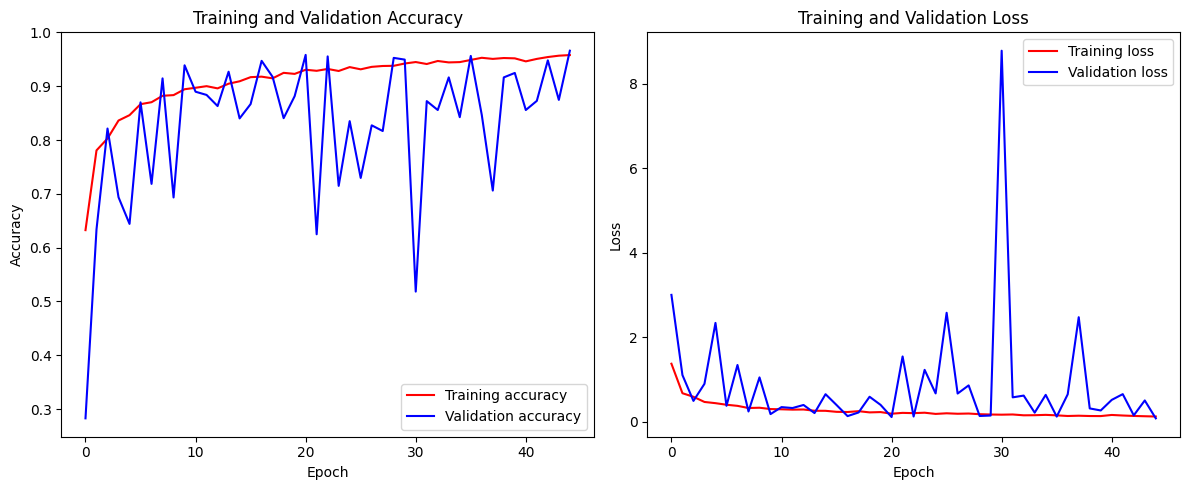

In [17]:
acc = history.history['accuracy']       # Ambil akurasi training dari history
val_acc = history.history['val_accuracy']   # Ambil akurasi validasi dari history
loss = history.history['loss']         # Ambil loss training dari history
val_loss = history.history['val_loss']     # Ambil loss validasi dari history

epochs = range(len(acc))  # Jumlah epoch

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')       # Garis merah = akurasi training
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') # Garis biru = akurasi validasi
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')         # Garis merah = loss training
plt.plot(epochs, val_loss, 'b', label='Validation loss')   # Garis biru = loss validasi
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Evaluasi model dengan test set

Kode ini digunakan untuk mengevaluasi performa model pada data test. Pertama, model memprediksi label untuk seluruh gambar di test set. Kemudian, hasil prediksi dibandingkan dengan label sebenarnya untuk membentuk confusion matrix dan classification report. Ini membantu mengetahui seberapa baik model mengenali setiap kelas, termasuk metrik seperti precision, recall, dan f1-score untuk masing-masing kelas.

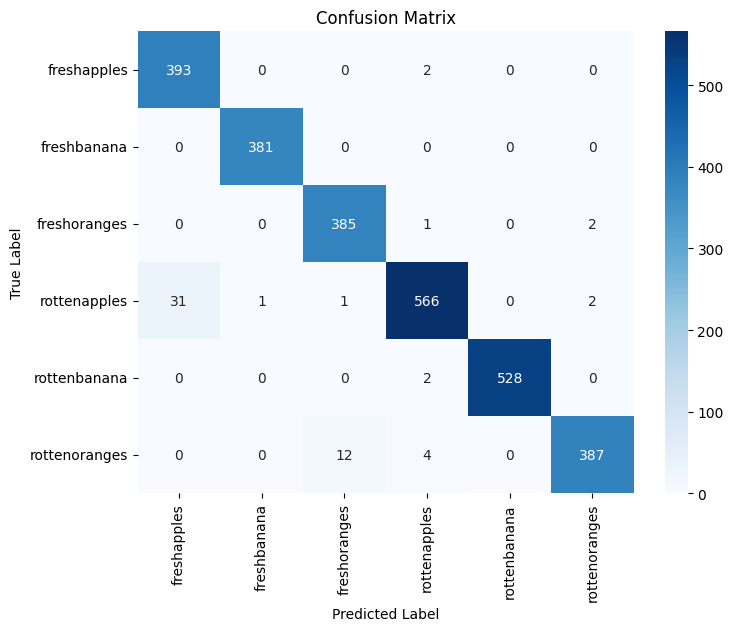


Classification Report:
               precision    recall  f1-score   support

  freshapples     0.9269    0.9949    0.9597       395
  freshbanana     0.9974    1.0000    0.9987       381
 freshoranges     0.9673    0.9923    0.9796       388
 rottenapples     0.9843    0.9418    0.9626       601
 rottenbanana     1.0000    0.9962    0.9981       530
rottenoranges     0.9898    0.9603    0.9748       403

     accuracy                         0.9785      2698
    macro avg     0.9776    0.9809    0.9789      2698
 weighted avg     0.9792    0.9785    0.9785      2698



In [18]:
test_generator.reset()  # Reset generator agar membaca data dari awal

# Mendapatkan prediksi dari model
predictions = model.predict(test_generator, steps=len(test_generator), verbose=0)
predicted_classes = np.argmax(predictions, axis=1)  # Mengambil indeks kelas dengan probabilitas tertinggi
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Menampilkan Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Save model

Kode ini menyimpan dan mengonversi model deep learning ke tiga format berbeda:

1. SavedModel (format standar TensorFlow)

2. TF-Lite (untuk perangkat mobile dan embedded)

3. TF.js (untuk penggunaan di browser).

Langkah ini penting untuk mendistribusikan model ke berbagai platform sesuai kebutuhan pengguna akhir.

In [19]:
export_dir = 'saved_model'
tflite_dir = 'tflite_model'
tfjs_dir = 'tfjs_model'

# 1. Simpan model dalam format TensorFlow SavedModel (standar untuk deployment)
tf.saved_model.save(model, export_dir)
print(f"Model berhasil disimpan dalam format SavedModel di: {export_dir}")

# 2. Konversi model SavedModel ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Simpan model TFLite ke file
os.makedirs(tflite_dir, exist_ok=True)  # Buat folder untuk model TFLite jika belum ada
tflite_file = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_file, 'wb') as f:  # Simpan model dalam format biner
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan dalam format TF-Lite di: {tflite_file}")

# 3. Coba impor tensorflowjs; jika gagal, install terlebih dahulu
try:
    import tensorflowjs as tfjs
except ImportError:
    print("⚠️ TensorFlow.js belum terinstal. Menginstal sekarang...")
    !pip install tensorflowjs
    import tensorflowjs as tfjs

# Konversi dan simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_dir)
print(f"Model berhasil dikonversi dan disimpan dalam format TF.js di: {tfjs_dir}")

Model berhasil disimpan dalam format SavedModel di: saved_model


Model berhasil dikonversi dan disimpan dalam format TF-Lite di: tflite_model/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi dan disimpan dalam format TF.js di: tfjs_model


Kode ini bertujuan untuk menyimpan model yang telah dilatih dalam tiga format berbeda—SavedModel, TensorFlow Lite (TFLite), dan TensorFlow.js (TFJS)—ke dalam Google Drive. Ini dilakukan agar model bisa digunakan untuk berbagai keperluan deployment: SavedModel untuk server-side, TFLite untuk perangkat mobile/embedded, dan TFJS untuk aplikasi web.

In [20]:
# Path untuk menyimpan model ke dalam 3 format berbeda di Google Drive
gdrive_export_dir = '/content/drive/My Drive/Model Deployment/saved_model'
gdrive_tflite_dir = '/content/drive/My Drive/Model Deployment/tflite_model'
gdrive_tfjs_dir = '/content/drive/My Drive/Model Deployment/tfjs_model'

# 1. Simpan model ke format SavedModel (standar format TensorFlow)
tf.saved_model.save(model, gdrive_export_dir)
print(f"Model berhasil disimpan dalam format SavedModel di Google Drive: {gdrive_export_dir}")

# 2. Konversi model ke format TFLite (untuk mobile/edge deployment)
converter = tf.lite.TFLiteConverter.from_saved_model(gdrive_export_dir)
tflite_model = converter.convert()

# Simpan file TFLite hasil konversi ke Google Drive
os.makedirs(gdrive_tflite_dir, exist_ok=True)  # Pastikan folder tujuan ada
tflite_file = os.path.join(gdrive_tflite_dir, 'model.tflite')
with open(tflite_file, 'wb') as f:  # Tulis model ke file .tflite
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan dalam format TF-Lite di Google Drive: {tflite_file}")

# 3. Konversi model ke format TensorFlow.js (untuk aplikasi web)
try:
    import tensorflowjs as tfjs
except ImportError:
    print("⚠️ TensorFlow.js belum terinstal. Menginstal sekarang...")
    !pip install tensorflowjs
    import tensorflowjs as tfjs

# Simpan model dalam format TFJS ke Google Drive
tfjs.converters.save_keras_model(model, gdrive_tfjs_dir)
print(f"Model berhasil dikonversi dan disimpan dalam format TF.js di Google Drive: {gdrive_tfjs_dir}")

Model berhasil disimpan dalam format SavedModel di Google Drive: /content/drive/My Drive/Model Deployment/saved_model


Model berhasil dikonversi dan disimpan dalam format TF-Lite di Google Drive: /content/drive/My Drive/Model Deployment/tflite_model/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi dan disimpan dalam format TF.js di Google Drive: /content/drive/My Drive/Model Deployment/tfjs_model
